<a href="https://colab.research.google.com/github/iRocktys/iBankys/blob/main/Previs%C3%A3oTemporal_ARIMA_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibilotecas e importacoes

In [4]:
# !pip install pmdarima

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import yfinance as yf

# ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

# PROPHET
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [6]:
acoes = ['BTC-USD']
star_date = '2020-01-01'
end_date = '2023-09-16'

# Criar DataFrame com pandas
acoes_df = pd.DataFrame()

# Buscando dos os fechamentos de preço das ações na data especificada
for acao in acoes:
  dados = yf.download(acao, start=star_date, end=end_date)
  acoes_df[acao] = dados['Close']

# Renomear nome das ações
acoes_df = acoes_df.rename(columns={'BTC-USD' : 'BTC'})

# Caso houver valores nulos retira-los do DataFrame
# acoes_df.isnull().sum()
acoes_df.dropna(inplace=True)

# Salvar em arquivo CSV
acoes_df.to_csv('acoes.csv')

[*********************100%%**********************]  1 of 1 completed


# Modelo ARIMA, previsões de series temporais


In [7]:
!pip install pmdarima

In [8]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
dateset = pd.read_csv('acoes.csv', parse_dates=['Date'], index_col='Date', date_parser= dateparse, usecols= ['Date', 'BTC'])

In [9]:
time_series = dateset['BTC']

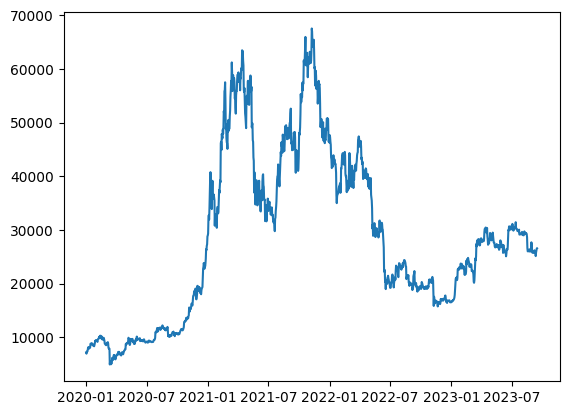

In [10]:
plt.plot(time_series);

In [11]:
figura = px.line(title='Historico do preço das ações')
figura.add_scatter(x = time_series.index, y = time_series)

In [12]:
time_series_datas = time_series['2020-01-01':'2023-09-15']
time_series_datas

Date
2020-01-01     7200.174316
2020-01-02     6985.470215
2020-01-03     7344.884277
2020-01-04     7410.656738
2020-01-05     7411.317383
                  ...     
2023-09-11    25162.654297
2023-09-12    25833.343750
2023-09-13    26228.324219
2023-09-14    26539.673828
2023-09-15    26608.693359
Name: BTC, Length: 1354, dtype: float64

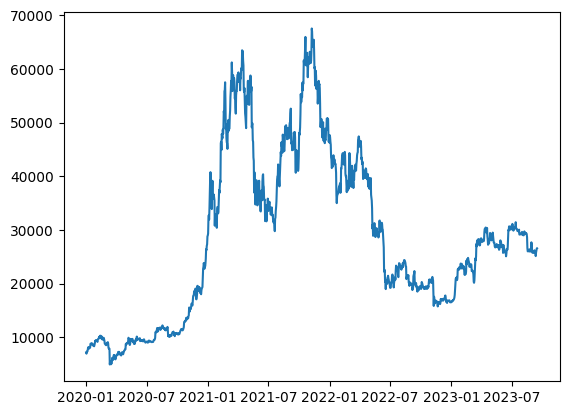

In [13]:
plt.plot(time_series_datas)

Decomposisão da série temporal

In [14]:
decomposicao = seasonal_decompose(time_series, period=len(time_series) // 2)

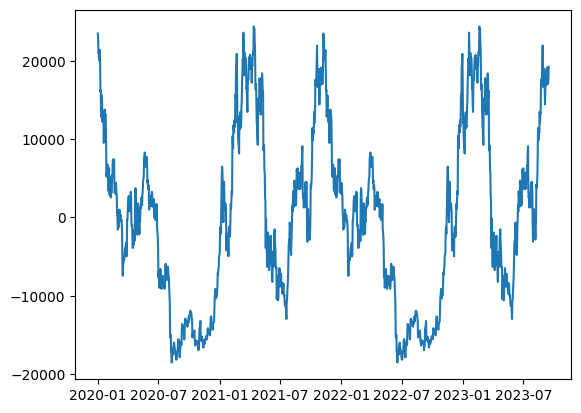

In [15]:
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
aleatorio = decomposicao.resid

plt.plot(sazonal);

Modelo ARIMA

In [16]:
modelo = auto_arima(time_series, suppress_warnings=True, error_action='ignore')

In [17]:
# Parâmetro P, Q D
modelo.order

(0, 1, 0)

In [18]:
previsoes = modelo.predict(n_periods=90)

In [19]:
previsoes

2023-09-16    26608.693359
2023-09-17    26608.693359
2023-09-18    26608.693359
2023-09-19    26608.693359
2023-09-20    26608.693359
                  ...     
2023-12-10    26608.693359
2023-12-11    26608.693359
2023-12-12    26608.693359
2023-12-13    26608.693359
2023-12-14    26608.693359
Freq: D, Length: 90, dtype: float64

In [20]:
treinamento = time_series[:90]
treinamento.index.min(), treinamento.index.max()

teste = time_series[90:]



In [21]:
modelo2 = auto_arima(treinamento, suppress_warnings=True, error_action='ignore')

In [22]:
teste.index

DatetimeIndex(['2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07',
               '2020-04-08', '2020-04-09',
               ...
               '2023-09-06', '2023-09-07', '2023-09-08', '2023-09-09',
               '2023-09-10', '2023-09-11', '2023-09-12', '2023-09-13',
               '2023-09-14', '2023-09-15'],
              dtype='datetime64[ns]', name='Date', length=1264, freq=None)

In [23]:
previsoes = pd.DataFrame(modelo2.predict(n_periods=273))
previsoes.index = teste.index
previsoes.columns = ['previsoes']

ValueError: Length mismatch: Expected axis has 273 elements, new values have 1264 elements

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(treinamento, label='Treinamento')
plt.plot(teste, label='Teste')
plt.plot(previsoes, label='Previsoes')
plt.legend();

In [ ]:
# Avaliar perda em reais nas previsoes
sum(abs(teste-previsoes['previsoes']) / len(teste))

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(teste, previsoes)

# Modelo PROPHET


In [ ]:
dataset = pd.read_csv('acoes.csv', usecols=['Date','BOVA'])
# Possui padrao na nomenclatura das colunas
dataset = dataset[['Date','BOVA']].rename(columns = {'Date':'ds', 'BOVA':'y'})

In [ ]:
modelo = Prophet()
modelo.fit(dataset)

In [ ]:
futuro = modelo.make_future_dataframe(periods=90)
previsoes = modelo.predict(futuro)

In [ ]:
modelo.plot(previsoes, xlabel = 'Data', ylabel = 'Preço')

In [ ]:
plot_plotly(modelo, previsoes)

In [ ]:
pred = modelo.make_future_dataframe(periods=0)
previsoes = modelo.predict(pred)
previsoes = previsoes['yhat'].tail(365)

In [ ]:
mean_absolute_error(teste, previsoes)